In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# LAB 1

In [84]:
nodes = pd.read_csv('Documentation/nodes.csv', header=None, names=["Node","x_position","y_position"], index_col=0)
edges = pd.read_csv('Documentation/links.csv', header=None, names=[
    "Link ID", 
    "Length (m)",
    "Number of lanes", 
    "Starting node ID",
    "Ending node ID", 
    "Region"], index_col=0)
occupancy = pd.read_csv('Documentation/occupancy.csv', index_col = 0)

time = 180
occupancy_at_t = occupancy.loc[time]
occupancy_at_t.name = f"Occupancy at time {time}"
edges_at_t = edges
edges_at_t["Occupancy"] = occupancy_at_t.values

print(edges_at_t)

         Length (m)  Number of lanes  Starting node ID  Ending node ID  \
Link ID                                                                  
512      109.223913                3             21109           19069   
513      129.668254                3             19067           21109   
514      133.572478                2             19065           21042   
516       47.649608                2                11           19201   
593       96.553539                3             18703              84   
...             ...              ...               ...             ...   
69622     13.724368                1             69623           19090   
70330     15.658167                2             20842           20876   
72127     12.171527                2             46751           46453   
73054      2.283717                2             20620           20620   
73546     80.753891                3             73547           41877   

         Region  Occupancy  
Link ID 

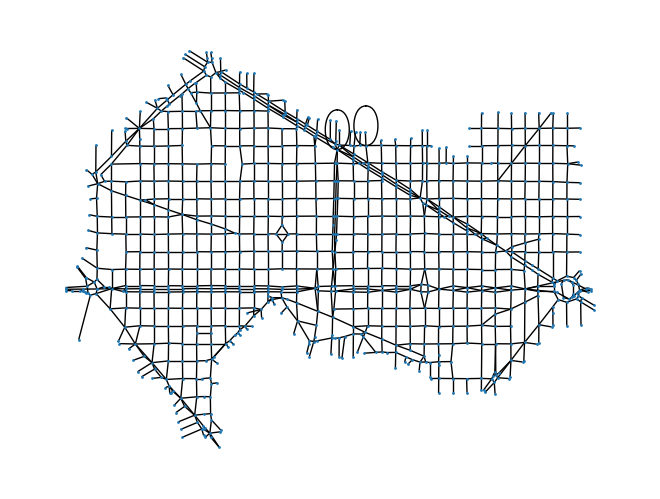

In [82]:
G = nx.from_pandas_edgelist(edges, source = "Starting node ID", target= "Ending node ID", edge_attr=["Length (m)", "Number of lanes", "Region","Occupancy"])
nx.draw(G, node_size = 1, pos=nodes.transpose())
plt.show()

# Old versions

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import csv

def printgraph(x,y,xname,yname,unit1, unit2):
    plt.plot(x,y,'o')
    plt.plot(x,y,'b')

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

graph_type = nx.Graph()

nodes = pd.read_csv('Documentation/nodes.csv', header=None)
nodes.columns = ["Node ID", "x_coordinate", "y_coordinate"]
nodescoordinates = nodes.iloc[:,1:]
nodesid = nodes.iloc[:,0]

links = pd.read_csv('Documentation/links.csv', header=None)
links.columns = ["Link ID", "Lenght", "Number of lanes", "Starting node ID", "Ending node ID", "Region"]

couple = pd.Series

#G = nx.from_pandas_edgelist(nodesid, source='x_coordinate', target='y_coordinate', create_using=graph_type)

G = nx.Graph()

G.add_nodes_from(nodes["Node ID"])
# G.add_edges_from(links[])

axes = plt.axes()

nx.draw(G, ax = axes)

# printgraph()

# print("test")


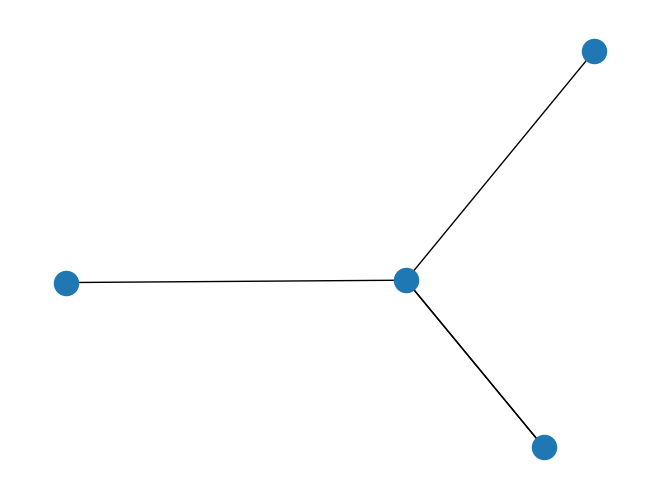

In [13]:
edges = pd.DataFrame(
    {
        "source": [0, 1, 2, 0],
        "target": [2, 2, 3, 2],
        "my_edge_key": ["A", "B", "C", "D"],
        "weight": [3, 4, 5, 6],
        "color": ["red", "blue", "blue", "blue"],
    }
)
G = nx.from_pandas_edgelist(
    edges,
    edge_key="my_edge_key",
    edge_attr=["weight", "color"],
    create_using=nx.MultiGraph(),
)
G[0][2]

nx.draw(G)
plt.show()